# <p style="padding:50px;background-color:#06402B;margin:0;color:#fafefe;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:100">Imports</p>

In [19]:
import re
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from model import QAModel
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from data import QADataset, Vocabulary, Tokenizer
from evaluate import compute_em, compute_f1

# <p style="padding:50px;background-color:#06402B;margin:0;color:#fafefe;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:100">Model Loading</p>

In [2]:
# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_dir = './model/qa_nn_with_conv_attention_no_clip/'
ckpt_file = 'qa_model_epoch_15.pt'

checkpoint = torch.load(os.path.join(checkpoint_dir, ckpt_file), map_location=device)

# Prepare validation vocab from any one checkpoint
val_vocab = checkpoint['vocab']

# Hyperparameters
embedding_dim = 300         # Embedding size for word embeddings
hidden_size = 128           # Hidden size for LSTM
num_layers = 1              # Number of LSTM layers
output_size = 400           
batch_size = 32
learning_rate = 0.001

model = QAModel(
    vocab=val_vocab,
    vocab_decoder=val_vocab.decoding,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size
).to(device)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

QAModel(
  (embedding_layer): Embedding(106348, 300, padding_idx=0)
  (start_decoder): BiLSTMModel(
    (lstm): LSTM(900, 128, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (end_decoder): BiLSTMModel(
    (lstm): LSTM(1800, 128, batch_first=True, bidirectional=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (start_linear): Linear(in_features=1156, out_features=1, bias=True)
  (end_linear): Linear(in_features=1156, out_features=1, bias=True)
)

# <p style="padding:50px;background-color:#06402B;margin:0;color:#fafefe;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:100">Visualization</p>

### 1. Read Validation Result

In [29]:
# Load the evaluation results from CSV
df = pd.read_csv("./out/qa_nn_with_conv_attention_no_clip/validation_output_epoch_15.csv")

# Compute extra columns if needed (for example, answer lengths)
df['gt_length'] = df['answer'].fillna('').apply(lambda x: len(x.split()))
df['pred_length'] = df['predicted_answer'].fillna('').apply(lambda x: len(x.split()))

# Compute F1 score for each row using the custom compute_f1 function
df['f1'] = df.apply(lambda row: compute_f1(row['predicted_answer'], row['answer']), axis=1)

# Define helper functions for answer length binning and question type extraction
def bin_length(length):
    return str(length) if length <= 9 else '>9'

def extract_question_type(question):
    if not question or pd.isna(question):
        return 'other'
    first_word = question.split()[0].lower()
    common = {'what', 'who', 'when', 'how', 'which', 'where', 'why'}
    return first_word if first_word in common else 'other'

# Create the new columns
df['length_bin'] = df['gt_length'].apply(bin_length)
df['question_type'] = df['question'].apply(extract_question_type)

### 2. Sample Of Output

In [28]:
required_cols = ['context', 'question', 'answer', 'predicted_answer',
                 'gt_length', 'pred_length', 'f1', 'length_bin', 'question_type']

df[required_cols].head(20).style.set_properties(**{
    'background-color': '#f9f9f9',
    'color': 'black',
    'border-color': 'gray',
    'text-align': 'left'
}).set_table_styles([{
    'selector': 'th',
    'props': [('background-color', '#40466e'),
              ('color', 'white'),
              ('text-align', 'left')]
}])

,context,question,answer,predicted_answer,gt_length,pred_length,f1,length_bin,question_type
0,"The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was limited by Denver's defense, which sacked him seven times and forced him into three turnovers, including a fumble which they recovered for a touchdown. Denver linebacker Von Miller was named Super Bowl MVP, recording five solo tackles, 2½ sacks, and two forced fumbles.",Who was the Super Bowl 50 MVP?,Von Miller,five,2,1,0.000000,2,who
1,"The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was limited by Denver's defense, which sacked him seven times and forced him into three turnovers, including a fumble which they recovered for a touchdown. Denver linebacker Von Miller was named Super Bowl MVP, recording five solo tackles, 2½ sacks, and two forced fumbles.",How many fumbles did Von Miller force in Super Bowl 50?,2,super bowl 50,1,3,0.000000,1,how
2,"The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was limited by Denver's defense, which sacked him seven times and forced him into three turnovers, including a fumble which they recovered for a touchdown. Denver linebacker Von Miller was named Super Bowl MVP, recording five solo tackles, 2½ sacks, and two forced fumbles.",Which team held the scoring lead throughout the entire game?,Broncos,broncos,1,1,1.000000,1,which
3,"The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was limited by Denver's defense, which sacked him seven times and forced him into three turnovers, including a fumble which they recovered for a touchdown. Denver linebacker Von Miller was named Super Bowl MVP, recording five solo tackles, 2½ sacks, and two forced fumbles.",Which Denver linebacker was named Super Bowl MVP?,linebacker Von Miller,solo,3,1,0.000000,3,which
4,"The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was limited by Denver's defense, which sacked him seven times and forced him into three turnovers, including a fumble which they recovered for a touchdown. Denver linebacker Von Miller was named Super Bowl MVP, recording five solo tackles, 2½ sacks, and two forced fumbles.",How many solo tackles did Von Miller make at Super Bowl 50?,five solo tackles,two,3,1,0.000000,3,how
5,"The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was limited by Denver's defense, which sacked him seven times and forced him into three turnovers, including a fumble which they recovered for a touchdown. Denver linebacker Von Miller was named Super Bowl MVP, recording five solo tackles, 2½ sacks, and two forced fumbles.",Who was limited by Denver's defense?,Newton was limited by Denver's defense,denver,6,1,0.000000,6,who
6,"The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was limited by Denver's defense, which sacked him seven times and forced him into three turnovers, including a fumble which they recovered for a touchdown. Denver linebacker Von Miller was named Super Bowl MVP, recording five solo tackles, 2½ sacks, and two forced fumbles.",How many times was Cam Newton sacked?,seven,seven,1,1,1.000000,1,how
7,"The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was limited by Denver's defense, which sacked him seven times and forced him into three turnovers, including a fumble which they recovered for a touchdown. Denver linebacker Von Miller was named Super Bowl MVP, recording five solo tackles, 2½ sacks, and two forced fumbles.",Who won the Super Bowl MVP?,Von Miller,von,2,1,0.666667,2,who
8,"The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was limited by Denver's defense, which sacked him seven times and forced him into three turnovers, including a fumble which they recovered for a touchdown. Denver linebacker Von Miller was named Super Bowl MVP, recording five solo tackles, 2½ sacks, and two forced fumbles.",How many turnovers did Cam Newton have?,three,seven,1

### 3. Score Distribution

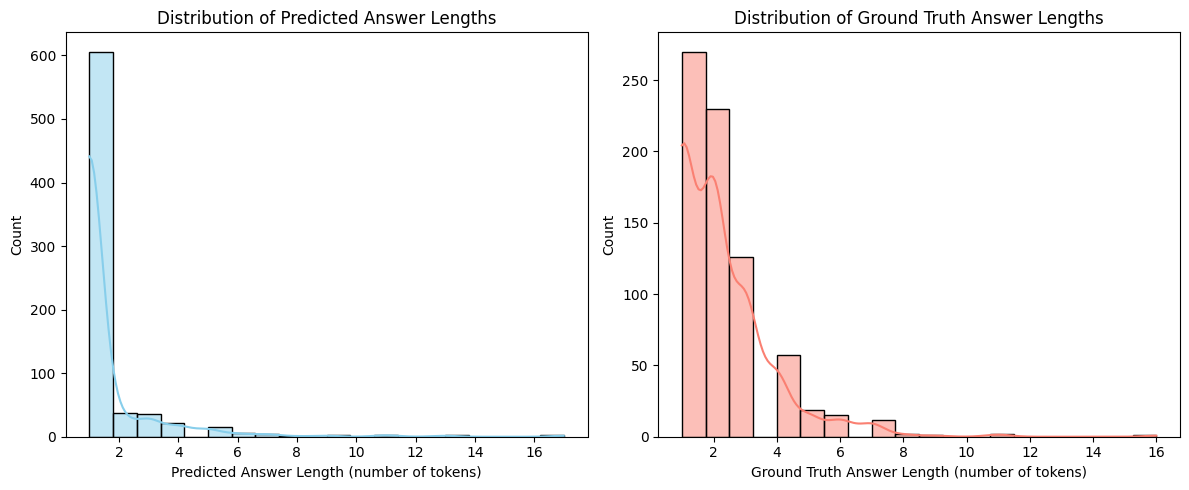

In [5]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['pred_length'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Predicted Answer Lengths")
plt.xlabel("Predicted Answer Length (number of tokens)")

plt.subplot(1, 2, 2)
sns.histplot(df['gt_length'], bins=20, kde=True, color='salmon')
plt.title("Distribution of Ground Truth Answer Lengths")
plt.xlabel("Ground Truth Answer Length (number of tokens)")

plt.tight_layout()
plt.show()

# Plot histogram of F1 Scores and EM scores
# For F1, assume that F1 is stored in a column, if not, you may compute it similarly
if "f1" in df.columns:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df['f1'], bins=20, kde=True, color='purple')
    plt.title("Distribution of F1 Scores")
    plt.xlabel("F1 Score")
    
    plt.subplot(1, 2, 2)
    sns.countplot(x='em', data=df, palette='viridis')
    plt.title("Count of Exact Match (EM) Results")
    plt.xlabel("Exact Match (0 = no, 1 = yes)")
    plt.ylabel("Count")
    
    plt.tight_layout()
    plt.show()

### 4. Performance Variation (F1 score) with Question Type (Categories: what, who, when, how, which, where, why, other)

In [31]:
def extract_question_type(question):
    if not question or pd.isna(question):
        return 'other'
    
    # Get the first token from the question
    first_word = question.split()[0].lower()
    common = {'what', 'who', 'when', 'how', 'which', 'where', 'why'}

    if first_word in common:
        return first_word
    
    return 'other'

df['question_type'] = df['question'].apply(extract_question_type)

# Compute mean F1 score for each question type
f1_by_qtype = df.groupby('question_type')['f1'].agg(['mean', 'count']).reset_index()
print("\nF1 score by Question Type:")
print(f1_by_qtype)


F1 score by Question Type:
  question_type      mean  count
0           how  0.202381     84
1         other  0.194102    116
2          what  0.095494    303
3          when  0.350496     48
4         where  0.087719     38
5         which  0.184669     41
6           who  0.225589     99
7           why  0.000000      6


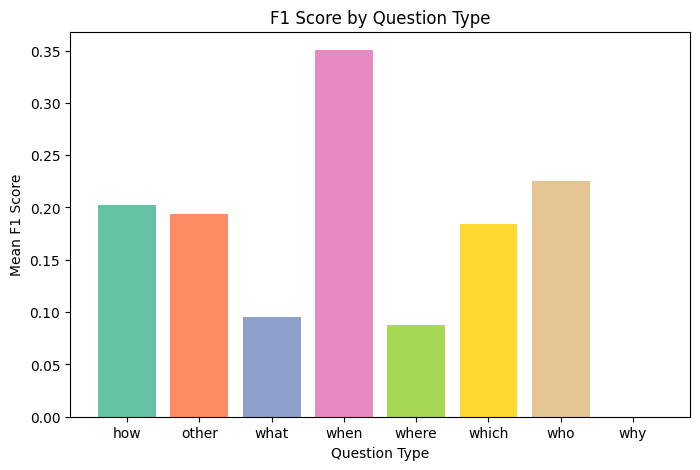

In [34]:
sorted_qtypes = sorted(f1_by_qtype['question_type'])
sorted_f1_qtype = f1_by_qtype.set_index('question_type').loc[sorted_qtypes].reset_index()
colors = cm.Set2(np.linspace(0, 1, len(sorted_f1_qtype)))

plt.figure(figsize=(8, 5))
bars = plt.bar(sorted_f1_qtype['question_type'], sorted_f1_qtype['mean'], color=colors)
plt.xlabel('Question Type')
plt.ylabel('Mean F1 Score')
plt.title('F1 Score by Question Type')
plt.show()

### 5. F1 score with respect to answer length bins (length 1, 2, 3, ..., >9)

In [35]:
# Compute mean F1 for each answer length bin
f1_by_length = df.groupby('length_bin')['f1'].agg(['mean', 'count']).reset_index()
print("F1 score by Answer Length:")
print(f1_by_length)

F1 score by Answer Length:
  length_bin      mean  count
0          1  0.197325    270
1          2  0.186922    230
2          3  0.128307    126
3          4  0.019883     57
4          5  0.098997     19
5          6  0.124868     15
6          7  0.090278     12
7          8  0.000000      2
8          9  0.000000      1
9         >9  0.035088      3


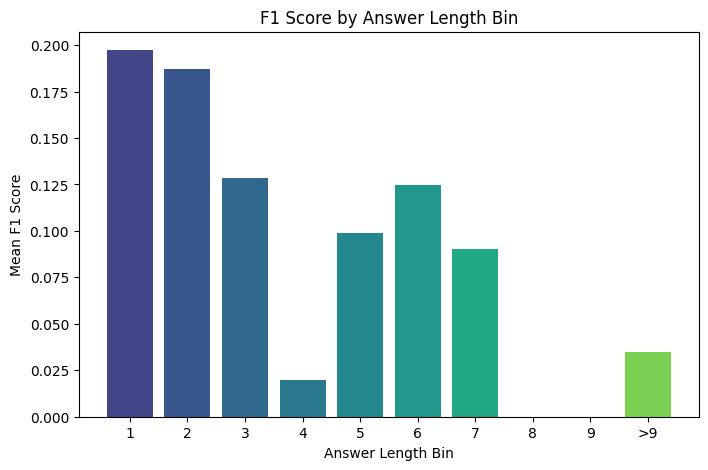

In [36]:
# Sort bins so that numerical values come in order (bins labeled with digits are sorted numerically)
sorted_bins = sorted(f1_by_length['length_bin'], key=lambda x: int(x) if x.isdigit() else 100)
sorted_f1_length = f1_by_length.set_index('length_bin').loc[sorted_bins].reset_index()
colors = cm.viridis(np.linspace(0.2, 0.8, len(sorted_f1_length)))

plt.figure(figsize=(8, 5))
bars = plt.bar(sorted_f1_length['length_bin'], sorted_f1_length['mean'], color=colors)
plt.xlabel('Answer Length Bin')
plt.ylabel('Mean F1 Score')
plt.title('F1 Score by Answer Length Bin')
plt.show()